# Desafio de ML

O objetivo é criar um modelo preditivo de regressão para prever o valor dos custos médicos individuais cobrados pelo seguro de saúde.

## Análise dos dados

A base de dados contém 1338 linhas com informações sobre as pessoas.

In [523]:
import pandas as pd
import numpy as np

path = "D:/Repos/FIAP/ML/files/insurance.csv"
df = pd.read_csv(path, sep=",")
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [524]:
df.shape

(1338, 7)

## Visualizando em gráficos
Considerando o fato de sabermos o impacto do cigarro na saúde, a coluna fumante parece ser relevante para nossa análise. Vamos ver em um gráfico como seria a distribuição fumantes x custo.

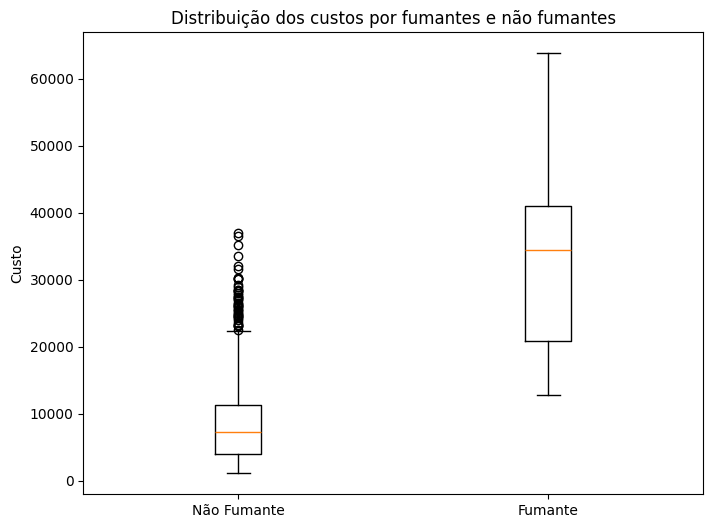

In [525]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.boxplot([df[df['smoker'] == 'no']['charges'], df[df['smoker'] == 'yes']['charges']],
            tick_labels=['Não Fumante', 'Fumante'])
plt.ylabel('Custo')
plt.title('Distribuição dos custos por fumantes e não fumantes')
plt.show()

Como vemos, a mediana de fumantes fica muito acima dos não fumantes, portanto confirma nossa suspeita de que seja um coluna relevante.

Vejamos a coluna 'children'

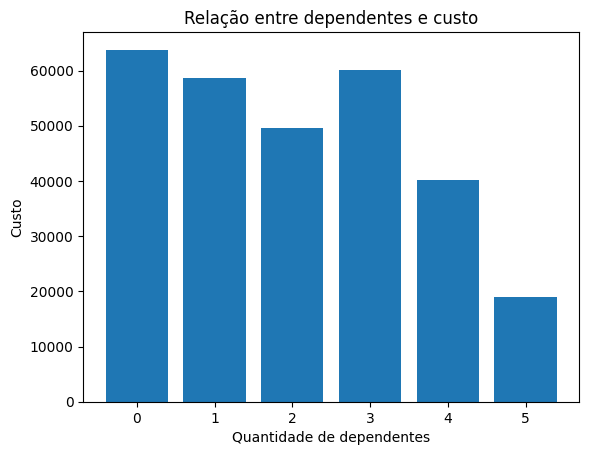

In [526]:
plt.bar(df['children'], df['charges'])
plt.xlabel('Quantidade de dependentes')
plt.ylabel('Custo')
plt.title('Relação entre dependentes e custo')
plt.show()

A influencia do numero de dependentes parece não ser muito relevante para a composição do custo.
Vejamos a idade

<Axes: xlabel='age', ylabel='charges'>

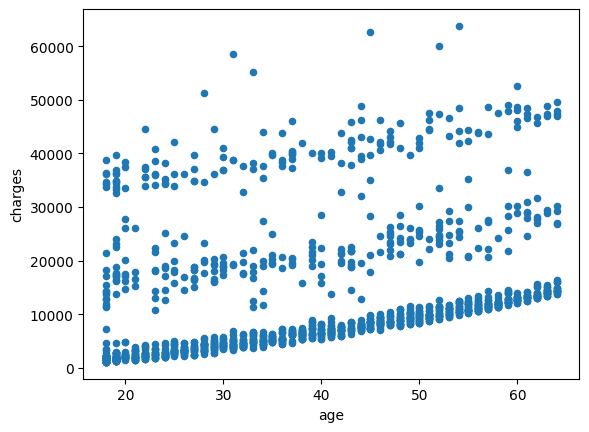

In [527]:
df.plot(kind="scatter", x="age", y="charges")

Interessante observar as linhas ascendentes conforme a idade aumenta, isso confirma a tendência esperada de aumento de preço por idade.

Vejamos se o sexo interfere no custo final

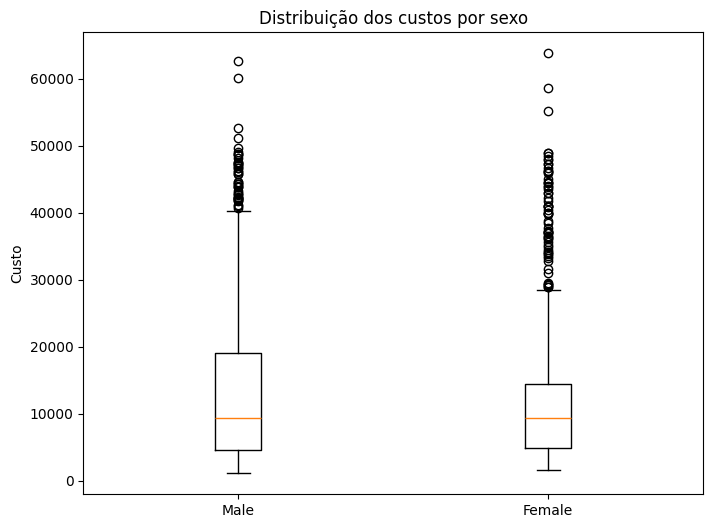

In [528]:
plt.figure(figsize=(8, 6))
plt.boxplot([df[df['sex'] == 'male']['charges'], df[df['sex'] == 'female']['charges']],
            tick_labels=['Male', 'Female'])
plt.ylabel('Custo')
plt.title('Distribuição dos custos por sexo')
plt.show()

A divisão dos custos por sexo parece ser bem equilibrada, a mediana em ambos está proximo a 10000. Há uma leve tendência a um maior gasto no sexo masculino como vemos nos quadrantes superiores e limites mais altos, apesar do outliers.

Vejamos o índice de massa corporal

<Axes: xlabel='bmi', ylabel='charges'>

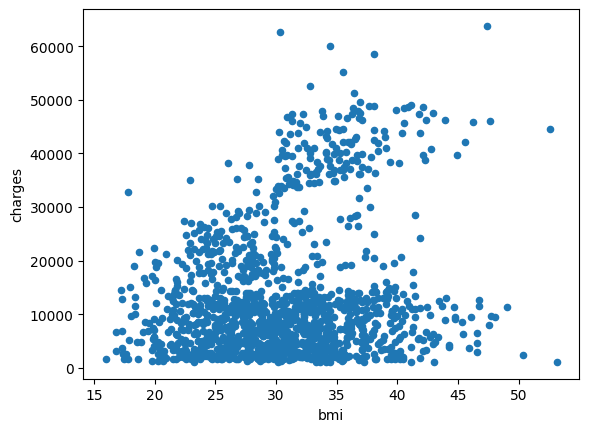

In [529]:
df.plot(kind="scatter", x="bmi", y="charges")

Interessante que a partir de bmi 30 temos um aumento razoavel nos custos.

Vejamos nossa ultima coluna: region

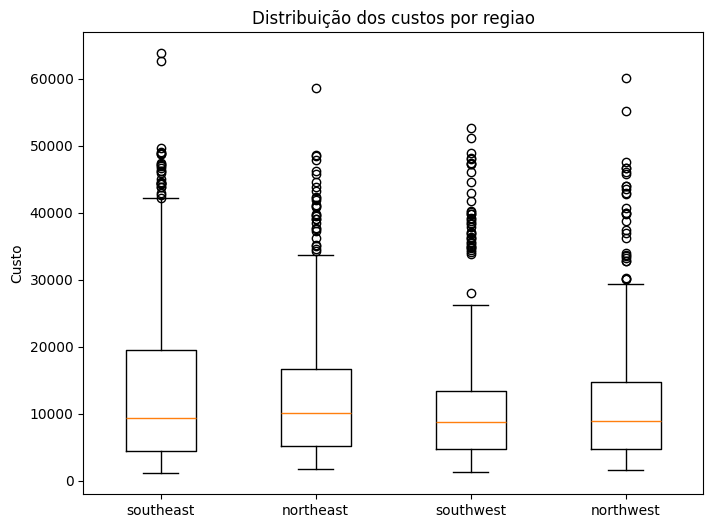

In [530]:
plt.figure(figsize=(8, 6))
plt.boxplot([df[df['region'] == 'southeast']['charges'], 
             df[df['region'] == 'northeast']['charges'],
             df[df['region'] == 'southwest']['charges'],
             df[df['region'] == 'northwest']['charges']],
            tick_labels=['southeast', 'northeast','southwest', 'northwest'])
plt.ylabel('Custo')
plt.title('Distribuição dos custos por regiao')
plt.show()

A distribuição é bem equilibrada, com uma leve alta na região southeast.

## Preparando os dados
Verificando como estão os dados, tipos e nulos.

In [531]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


**Verificando os dados não numericos**

Vou verificar as colunas de texto para verificar quantos rotulos diferentes existem para cada caso

In [532]:
df["sex"].value_counts()

sex
male      676
female    662
Name: count, dtype: int64

A coluna "smoker" é desproporcional, precisaremos trabalhar mais à frente a amostragem desses dados para equilibrar os sets de treino e teste.
Vamos convertê-la usando o *LabelEncoder*.

In [533]:
df["smoker"].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [534]:
df["region"].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

**Utilizando LabelEncoder**
Vou usar o *LabelEncoder* para converter a coluna 'smoker'.

In [535]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['smoker_bin'] = label_encoder.fit_transform(df['smoker'])
print(df[['smoker', 'smoker_bin']].head())
df.drop(columns=['smoker'], inplace=True)

  smoker  smoker_bin
0    yes           1
1     no           0
2     no           0
3     no           0
4     no           0


<Axes: >

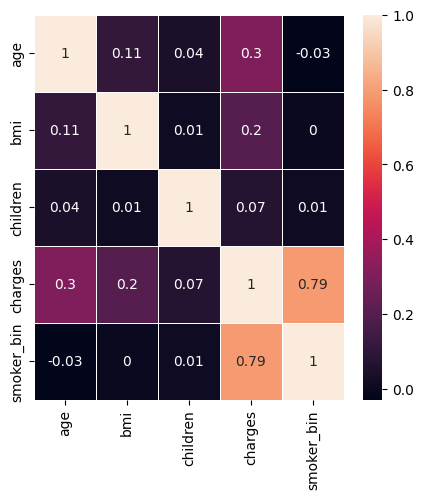

In [537]:
import seaborn as sns

correlation_matrix = df.select_dtypes(include='number').corr().round(2)
fig, ax = plt.subplots(figsize=(5,5))    
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

**Utilizando One-Hot Encoding**

Vou usar o *OneHotEncoder* para converter os outros tipos textuais. Primeiro um teste com a coluna 'region'.

In [488]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()

region_1hot = one_hot_encoder.fit_transform(df[["region"]])
region_1hot.toarray()[:10]

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [489]:
one_hot_encoder.categories_

[array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

**Criando um Pipeline**

Vou criar um pipeline com *StandardScaler* para normalizar os dados.

In [490]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()), # padronizando as escalas dos dados
    ])

**Efetuando o divisão de dados para treino e teste**

Como a quantidade de dados para fumantes e não fumantes é muito diferente e essa é uma feature com grande peso, precisamos equilibrar a amostragem para que dados de treino e teste reflitam a mesma proporção.

In [491]:
X = df
y = df['charges']

from sklearn.model_selection import train_test_split

# Estratificar por smoker_bin
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['smoker_bin']
)
X_train.shape

(1070, 7)

In [538]:
# Após o split, verificar se as distribuições são semelhantes
print("Treino - charges:")
print(y_train.describe())
print("\nTeste - charges:")
print(y_test.describe())

Treino - charges:
count     1070.000000
mean     13285.111927
std      12100.847317
min       1121.873900
25%       4763.252250
50%       9401.175500
75%      16862.795985
max      63770.428010
Name: charges, dtype: float64

Teste - charges:
count      268.000000
mean     13211.773243
std      12169.043143
min       1146.796600
25%       4504.920963
50%       9296.364300
75%      15621.566312
max      52590.829390
Name: charges, dtype: float64


Vou usar o **ColumnTransformer** para efetuar os ajustes.

In [492]:
from sklearn.compose import ColumnTransformer

colunas_numericas = df.select_dtypes(include='number').columns.tolist()
colunas_numericas = [col for col in colunas_numericas if col != 'smoker_bin' and col != 'charges']
print(colunas_numericas)
colunas_texto = df.select_dtypes(exclude='number').columns.tolist()
print(colunas_texto)

pipeline = ColumnTransformer([
        ("num", num_pipeline, colunas_numericas), #tratando as variáveis numéricas
        ("cat", OneHotEncoder(), colunas_texto),
        ("pass", "passthrough", ["smoker_bin"]) # tratando as variáveis categóricas
    ])

train_prepared = pipeline.fit_transform(X_train)

['age', 'bmi', 'children']
['sex', 'region']


In [493]:
train_prepared

array([[-1.00715695, -0.656649  ,  1.56520739, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.1331464 ,  0.3949374 ,  1.56520739, ...,  0.        ,
         0.        ,  0.        ],
       [-1.50603966,  1.00636332, -0.91471153, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.50827423,  1.08661814, -0.08807189, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.41822224, -0.35879605,  0.73856775, ...,  1.        ,
         0.        ,  0.        ],
       [-1.36350174,  0.19057718, -0.91471153, ...,  0.        ,
         0.        ,  0.        ]], shape=(1070, 10))

In [494]:
type(train_prepared)

numpy.ndarray

Vou reconstruir o dataframe incluindo os nomes das novas colunas

In [495]:
sex_cat, region_cat = pipeline.named_transformers_["cat"].categories_
print(sex_cat)
print(region_cat)

['female' 'male']
['northeast' 'northwest' 'southeast' 'southwest']


Reorganizando as colunas para alinhar com os dados após o pipeline.

In [496]:
novas_colunas = []
for col in colunas_numericas + colunas_texto + ["smoker_bin"]:
    if col == 'sex':
        novas_colunas.extend([f'sex_{cat}' for cat in sex_cat])
    elif col == 'region':
        novas_colunas.extend([f'region_{cat}' for cat in region_cat])    
    else:
        novas_colunas.append(col)

print(novas_colunas)

['age', 'bmi', 'children', 'sex_female', 'sex_male', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest', 'smoker_bin']


Criando o novo dataframe.

In [497]:
X_train_prepared = pd.DataFrame(data=train_prepared, columns=novas_colunas)
X_train_prepared

,age,bmi,children,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker_bin
0,-1.007157,-0.656649,1.565207,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.133146,0.394937,1.565207,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-1.506040,1.006363,-0.914712,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.845836,1.477964,-0.088072,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.061877,-0.736904,-0.088072,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1065,-0.437005,1.934672,-0.088072,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1066,-0.722081,-0.194977,-0.088072,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1067,-0.508274,1.086618,-0.088072,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1068,0.418222,-0.358796,0.738568,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [498]:
X_train_prepared.describe()

,age,bmi,children,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker_bin
count,1.070000e+03,1.070000e+03,1.070000e+03,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000
mean,-2.241198e-16,3.685525e-16,6.640586e-17,0.491589,0.508411,0.244860,0.242991,0.271963,0.240187,0.204673
std,1.000468e+00,1.000468e+00,1.000468e+00,0.500163,0.500163,0.430205,0.429090,0.445179,0.427397,0.403651
min,-1.506040e+00,-2.450386e+00,-9.147115e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-9.180707e-01,-7.172538e-01,-9.147115e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-9.391517e-03,-4.522308e-02,-8.807189e-02,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.458360e-01,6.340471e-01,7.385678e-01,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.772332e+00,3.700278e+00,3.218487e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [521]:
(X_test["smoker_bin"] == 1).sum() / X_test.shape[0] # Verificando a proporção de fumantes

np.float64(0.20522388059701493)

In [520]:
(X_train["smoker_bin"] == 1).sum() / X_train.shape[0]

np.float64(0.2046728971962617)

Verificando se há algum nulo

In [499]:
X_train_prepared.isnull().sum()

age                 0
bmi                 0
children            0
sex_female          0
sex_male            0
region_northeast    0
region_northwest    0
region_southeast    0
region_southwest    0
smoker_bin          0
dtype: int64

## Treinando o modelo de regressão linear

Vamos utilizar o *LinearRegression* para efetuar a predição.

In [500]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Aplicando o pipeline aos dados de teste

In [501]:
test_prepared = pipeline.transform(X_test)
X_test_prepared = pd.DataFrame(data=test_prepared, columns=novas_colunas)
X_test_prepared

,age,bmi,children,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker_bin
0,-0.579543,-0.375343,3.218487,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,-0.579543,-0.359623,-0.088072,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.558526,-1.601505,-0.914712,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.080660,1.039458,-0.088072,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,-1.434771,-0.579704,0.738568,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
263,1.487257,1.511059,-0.914712,0.0,1.0,0.0,0.0,0.0,1.0,1.0
264,0.560760,-0.231381,-0.088072,1.0,0.0,0.0,0.0,1.0,0.0,0.0
265,-1.506040,0.150863,0.738568,0.0,1.0,0.0,0.0,1.0,0.0,1.0
266,1.558526,0.253457,0.738568,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [502]:
prediction = lin_reg.predict(X_test_prepared)
prediction[:5]

# Arredonda os valores para facilitar a leitura
resultados = pd.DataFrame({
    'Predito': np.round(prediction[:5], 2),
    'Real': np.round(y_test[:5].values, 2)
})

print(resultados)

    Predito      Real
0   8034.02   6799.46
1   5644.61   4243.59
2  10705.70  13415.04
3  10638.66   6079.67
4   2606.83  22493.66


## Avaliando o modelo

In [503]:
y_test.describe()

count      268.000000
mean     13211.773243
std      12169.043143
min       1146.796600
25%       4504.920963
50%       9296.364300
75%      15621.566312
max      52590.829390
Name: charges, dtype: float64

### Utilizando o MSE
A métrica *MSE (mean squared error, ou erro quadrático médio)* mostra o quanto, em média, as previsões do modelo estão distantes dos valores reais, elevando ao quadrado cada diferença. Quanto menor o MSE, melhor o modelo está ajustado aos dados. Valores altos indicam que as previsões estão, em média, longe dos valores reais.

In [504]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(y_test, prediction)
lin_rmse = np.sqrt(lin_mse) # raiz quadrada aqui
print(f"MSE: {lin_mse:.2f}")
print(f"RMSE: {lin_rmse:.2f}") # média na unidade original

MSE: 31151264.04
RMSE: 5581.33


### Utilizando o MAE 
O *MAE (mean absolute error, ou erro absoluto médio)* mostra, em média, o quanto as previsões do modelo estão distantes dos valores reais, considerando apenas o valor absoluto das diferenças. Ou seja, ele indica o erro médio em unidades reais (por exemplo, reais ou dólares). Quanto menor o MAE, melhor o modelo está ajustado. Valores altos indicam que as previsões estão, em média, longe dos valores reais.

In [505]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_test, prediction)
print(f"MAE: {lin_mae:.2f}")

MAE: 3869.32


### Verificando o Score R²

O *Score R² (coeficiente de determinação)* mede o quanto o modelo consegue explicar a variação dos valores reais da variável alvo (neste caso, os custos do seguro). Ele varia de 0 a 1 e mostra o quanto o modelo está ajustado aos dados.

In [506]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, prediction)
print(f"r²={r2}, ou seja {(r2*100):.2f}% de ajuste")

r²=0.7888523049204453, ou seja 78.89% de ajuste


### Calculando o MAPE
O *MAPE (Mean Absolute Percentage Error, ou erro percentual absoluto médio)* mostra, em média, qual foi o erro das previsões do modelo em relação aos valores reais, mas em formato percentual. Por exemplo, um MAPE de 10% indica que, em média, as previsões ficaram 10% acima ou abaixo dos valores reais. Quanto menor o MAPE, mais preciso é o modelo. É útil para comparar o desempenho entre diferentes modelos ou conjuntos de dados, pois o resultado é sempre uma porcentagem.


In [507]:
def calculate_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape

mape_result = calculate_mape(y_test, prediction)

# Imprimir o resultado
print(f"O MAPE é: {mape_result:.2f}%")

O MAPE é: 38.22%


### Julgamento do modelo *LinearRegression*
Como vimos, obtivemos RMSE: 5581.33, score r² de 78.89% e taxa MAPE de 38.22%. O erro médio absoluto é de ~3869 USD.

O modelo não é péssimo, mas gostaria de uma taxa de acurrácia maior. Para tanto tentaremos outro modelo.

## Utilizando o *Random Forest Regressor*

O Random Forest Regressor utiliza várias árvores de decisão e combina os resultados. Cada árvore faz uma estimativa e o resultado final é a média dessas previsões.

In [508]:
from sklearn.ensemble import RandomForestRegressor

# Treinando o modelo
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_prepared, y_train)

# Fazendo previsões
rf_pred = rf_reg.predict(X_test_prepared)

# Avaliando o modelo
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_mape = calculate_mape(y_test, rf_pred)

print(f"Score R²: {rf_r2:.2f}")
print(f"MSE: {rf_mse:.2f}")
print(f"RMSE: {np.sqrt(rf_mse):.2f}")
print(f"MAE: {rf_mae:.2f}")
print(f"MAPE: {rf_mape:.2f}%")

Score R²: 0.85
MSE: 22585138.94
RMSE: 4752.38
MAE: 2816.54
MAPE: 37.96%


### Comparativo dos modelos LinearRegression vs RandomForestRegressor

Abaixo está um resumo dos principais resultados dos dois modelos para facilitar a análise:

| Métrica         | LinearRegression | RandomForestRegressor|
|-----------------|------------------|----------------------|
| Score R²        | 0.79             | 0.85                 |
| MSE             | 31151264         | 22585138             |
| RMSE            | 5581.33          | 4752.38              |
| MAE             | 3869.32          | 2816.54              |
| MAPE (%)        | 38.22            | 37.96                |


**Interpretação:**
- O RandomForestRegressor apresentou sutis melhores resultados em todas as métricas, indicando maior capacidade de ajuste e previsões mais próximas dos valores reais.
- O RMSE e o MAE menores significam que o erro médio das previsões diminuiu.
- O MAPE menor mostra que o erro percentual médio também foi reduzido.
- O Score R² mais alto indica que o modelo explica melhor a variação dos custos.
